C:\Users\deys\Desktop\NLP_Projects\Projects\Product Categorization\Product-Categorization-NLP-master\Product-Categorization-NLP-master

Importing packages and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report



In [18]:
from google.colab import files
uploaded = files.upload()

Saving bugs_classification.csv to bugs_classification (1).csv


In [19]:
df = pd.read_csv("bugs_classification (1).csv")

In [20]:
df.head()

,pr,summary,category,Unnamed: 3
0,1507709,[SRX1500] KMD hung and caused high RE CPU . Al...,generic,Ipsec/
1,1512268,kmd coredump on vSRX running 18.4X5.21512268W...,generic,Ipsec/
2,1517262,Flowd Core dump causing failover1517262The cra...,rekey,NaN
3,1517347,DT-[IPsec Munich (SPC3): eNB not able to estab...,generic,ipsec/
4,1517718,[VSRX] flowd went down and after few minutes F...,configuration,Ipsec/


In [21]:
df = df.drop('Unnamed: 3' ,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pr        86 non-null     int64 
 1   summary   86 non-null     object
 2   category  86 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.1+ KB


#Data Cleaning
For our analysis we use only two variables: summary and category

In [23]:
text_df = df[['summary', 'category']]
text_df.head()

,summary,category
0,[SRX1500] KMD hung and caused high RE CPU . Al...,generic
1,kmd coredump on vSRX running 18.4X5.21512268W...,generic
2,Flowd Core dump causing failover1517262The cra...,rekey
3,DT-[IPsec Munich (SPC3): eNB not able to estab...,generic
4,[VSRX] flowd went down and after few minutes F...,configuration


In [24]:
text_df = text_df.replace(r'\n',' ', regex=True) 

In [25]:
text_df.shape

(86, 2)

In [26]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   summary   86 non-null     object
 1   category  86 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


In [27]:
text_df.isnull().sum()

summary     0
category    0
dtype: int64

In [28]:
text_df['summary'][10]

"IPSEC SRX Leipzig, Failover/Coredump after Configuration1555867PR: 1555867 Description: The fix is to 1) don't free the ts_pair if there is at least one prefix which has been added into the radix tree 2) allow the duplicated prefix in the addr_list  When multiple prefixes for one tunnel are added into Radix tree, if one of the prefixes fails to be added into the Radix tree, then ts_pair will be freed. However, the prefixes which have been added into the Radix tree still keep a pointer to the ts_pair. If a packet hits this prefix, then the coredump will occur.  This issue might be seen if the following conditions are met: * On SRX platform * IPSec VPN is used * Traffic selector configuration with multiple prefixes * One of the prefix addition failure leading to ts_pair freed   On SRX-Series devices, coredump/redundancy group failover might be observed due to an invalid traffic selector which has been freed in radix tree.  "

In [29]:
##Data type change:

text_df['summary'] = text_df['summary'].astype(str)

We have 6138 words in the data.

In [30]:
print(text_df['summary'].apply(lambda x: len(x.split(' '))).sum())

15686


In [31]:
text_df.category.unique()

array(['generic', 'rekey', 'configuration', 'memory_issue',
       'IPsec_routing', 'NATT'], dtype=object)

We have above five group of categories. 

#Data analysis

In [32]:
text_df.category.value_counts()

configuration    29
generic          25
rekey            14
memory_issue      8
IPsec_routing     5
NATT              5
Name: category, dtype: int64

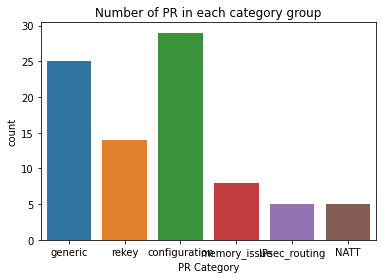

In [33]:
sns.countplot(x='category',data=text_df)
plt.xlabel('PR Category')
plt.title('Number of PR in each category group');

In [183]:
# Class disctribution to check imbalance dataset
text_df.category.value_counts()
configuration = len(text_df[text_df['category'] == 'configuration'])
generic = len(text_df[text_df['category'] == 'generic'])
rekey = len(text_df[text_df['category'] == 'rekey'])
memory_issue = len(text_df[text_df['category'] == 'memory_issue'])
IPsec_routing = len(text_df[text_df['category'] == 'IPsec_routing'])
NATT = len(text_df[text_df['category'] == 'NATT'])

class_distribution_ratio = configuration/NATT/generic

In [184]:
print(class_distribution_ratio)

0.23199999999999998


##Text Pre-processing
We are removing non-alphabetic characters, the stopwords and lemmatizing for each line of text.



In [34]:
text_df.head(2)

,summary,category
0,[SRX1500] KMD hung and caused high RE CPU . Al...,generic
1,kmd coredump on vSRX running 18.4X5.21512268W...,generic


In [35]:
#"""The function to remove punctuation"""

def remove_punctuation(description):
    
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)
text_df['summary'] = text_df['summary'].apply(remove_punctuation)


In [36]:
# This function converts a text to a sequence of words:


def tokens(words):
    words = re.sub("[^a-zA-Z]"," ",words)
    text = words.lower().split()
    return " ".join(text)
text_df['summary'] = text_df['summary'].apply(tokens)


In [39]:
text_df['summary'][0]

'srx kmd hung and caused high re cpu all vpn traffic impacted when some ike p sa is marked unusable the key for getnext in the next patricia tree look up was modified partially this partial key modification caused a loop in the patricia tree look up as a result kmd hung audittrail events whats the general trigger of this pr bob sometimes the patricia tree loop if the key is not a real key all vpn traffic impacted and re utilization is high due to the kmd process crashes this issue can be observed by the following command this issue might be seen if the following conditions are met on srx platforms ipsec is configured using snmp to get ike sa information for example running cli command show snmp mib walk jnxipsecflowmonphaseone on all srx platforms with ipsec is configured if using snmp to get ike sa information the kmd process may crash as a result all ipsec vpn traffic will be impacted'

In [40]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#We build the function to apply lemmatizing:
lem = WordNetLemmatizer()

def word_lem(text_df):
    lem_text = [lem.lemmatize(word) for word in text_df.split()]
    return " ".join(lem_text)

text_df['summary']  = text_df['summary'].apply(word_lem)
text_df.head()

In [43]:
text_df['summary'][12]

'traffic go through ipsec tunnel wa dropped by tunnel invalid in pfe the time sequence for rekey in dut is after sec swap key after th sec ike sends delete old key pfe start sec timer to delete backup nsptunnel after th sec pfe deletes backup nsptunnel denote t rekey start t swap key t delete old key t free old key backup naptunnel in theory the riskwindow in dut is t t ie second the time when the issue occurs depend on when the new key is used in vpn peer and when the swap key is done in dut in the following we always suppose that the swap key in dut is done at t in vpn peer if the new key is used for encryption at t ie perfect sync between device then the issue will not occur in reality the perfect sync cannot be achieved so we have the following two case note old key is used before the new key case the new key start to be used for encryption in vpn peer is earlier than t in other word old key is used in t t t t case the new key start to be used for encryption in vpn peer is later th

In [44]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [45]:
##We build the function for stop word removal:

stop = stopwords.words('english')
#print(stop[::10])
def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)
text_df['summary'] = text_df['summary'].apply(remove_stopwords)

In [ ]:
text_df


#Pos Tagging
To get the deeper insight to the way in which that word is used in speech, the Part of speech (POS) tagging method has been used. There are eight primary parts of speech and they each have a corresponding tag. The NLTK libary has a method to perform POS tagging.

The example of Pos Tagging on analyzed data set is presented below:

In [47]:
>>> import nltk
>>> nltk.download('punkt')
>>> nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
tokens = text_df['summary'][0]

nltk.pos_tag(word_tokenize(tokens))

#Label Encoding of category

In [49]:
from sklearn import preprocessing

In [50]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(text_df['category'])
text_df['label'] = label_encoder.transform(text_df['category'])

In [51]:
text_df.head(2)

,summary,category,label
0,srx kmd hung caused high cpu vpn traffic impac...,generic,3
1,kmd coredump vsrx running x multiple trafficse...,generic,3


#Bag of words
To run machine learning algorithms we need to convert the text files into numerical feature vectors. We will use bag of words model for our analysis. In general we segment each text file into words and count of times each word occurs in each document and finally assign each word an integer id. Each unique word in our dictionary will correspond to a feature (descriptive feature).

More precisely we will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer).

In [52]:
vectorizer = CountVectorizer()
vectorizer.fit(text_df['summary'])
vector = vectorizer.transform(text_df['summary'])

In [53]:
print(vector.shape)
print(vector.toarray())

(86, 1434)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#TF-IDF
Term Frequency–Inverse Document Frequency:  It can be defined as the calculation of how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (data-set)

In [90]:
type(vector)

scipy.sparse.csr.csr_matrix

In [54]:
# extract the tfid representation matrix of the text data
tfidf_converter = TfidfTransformer()
X_tfidf = tfidf_converter.fit_transform(vector).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [143]:

#Spliting the data into train and test sets:
X = text_df['summary']
y = text_df['category']
#y = text_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)


In [144]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((68,), (18,), (68,), (18,))

#Models
We used the Multi-Classification models.

The classification models evaluated are:



*   Logistic Regression,
*   Linear Support Vector Machine,
*   Multinomial Naive Bayes
*   Random Forest
*   Gradient Boosting




#Pipeline
We build a pipeline. We can write less code and do all of the above, by building a pipeline as follows.

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn.

#Logistic Regression
We build and train Logistic Regression model:

In [145]:
model_log = Pipeline([('vect', CountVectorizer(min_df=3, ngram_range=(1,2))),
                      ('X_tfidf', TfidfTransformer()),
                      ('model',LogisticRegression()),
                     ])

model_log.fit(X_train, y_train)

ytest = np.array(y_test)
pred = model_log.predict(X_test)

The confusion matrix and classification report(precision, recall, F1-score):

In [146]:
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.2777777777777778
               precision    recall  f1-score   support

IPsec_routing       0.00      0.00      0.00         2
configuration       0.29      1.00      0.44         4
      generic       0.25      0.14      0.18         7
 memory_issue       0.00      0.00      0.00         1
        rekey       0.00      0.00      0.00         4

     accuracy                           0.28        18
    macro avg       0.11      0.23      0.13        18
 weighted avg       0.16      0.28      0.17        18



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#SVM

In [147]:
svc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',LinearSVC()),
               ])

svc.fit(X_train, y_train)

ytest = np.array(y_test)
y_pred = svc.predict(X_test)

In [148]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))

accuracy 0.5555555555555556
               precision    recall  f1-score   support

IPsec_routing       0.00      0.00      0.00         2
configuration       0.33      0.50      0.40         4
      generic       0.57      0.57      0.57         7
 memory_issue       1.00      1.00      1.00         1
        rekey       1.00      0.75      0.86         4

     accuracy                           0.56        18
    macro avg       0.58      0.56      0.57        18
 weighted avg       0.57      0.56      0.56        18



#Naive Bayes Classifier for Multinomial Models

In [149]:
nbc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',MultinomialNB()),
               ])

nbc.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = nbc.predict(X_test)

In [150]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.2777777777777778
               precision    recall  f1-score   support

IPsec_routing       0.00      0.00      0.00         2
configuration       0.25      1.00      0.40         4
      generic       0.50      0.14      0.22         7
 memory_issue       0.00      0.00      0.00         1
        rekey       0.00      0.00      0.00         4

     accuracy                           0.28        18
    macro avg       0.15      0.23      0.12        18
 weighted avg       0.25      0.28      0.18        18



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Random Forest

In [153]:
rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('rf', RandomForestClassifier(n_estimators=100)),
               ])

rf.fit(X_train, y_train)

ytest = np.array(y_test)
preds = rf.predict(X_test)

In [154]:
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.3888888888888889
               precision    recall  f1-score   support

IPsec_routing       0.00      0.00      0.00         2
configuration       0.25      0.75      0.38         4
      generic       0.50      0.29      0.36         7
 memory_issue       0.00      0.00      0.00         1
        rekey       1.00      0.50      0.67         4

     accuracy                           0.39        18
    macro avg       0.35      0.31      0.28        18
 weighted avg       0.47      0.39      0.37        18



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Gradient Boosting

In [161]:
model_gb = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,3))),
                    ('tfidf', TfidfTransformer()),
                    ('gb', GradientBoostingClassifier(n_estimators=100)),
                    ])

model_gb.fit(X_train, y_train)

ytest = np.array(y_test)
predicted = model_gb.predict(X_test)

In [162]:
print('accuracy %s' % accuracy_score(predicted, y_test))
print(classification_report(ytest, predicted))

accuracy 0.5
               precision    recall  f1-score   support

IPsec_routing       0.33      0.50      0.40         2
configuration       0.25      0.50      0.33         4
      generic       1.00      0.29      0.44         7
 memory_issue       0.50      1.00      0.67         1
        rekey       1.00      0.75      0.86         4

     accuracy                           0.50        18
    macro avg       0.62      0.61      0.54        18
 weighted avg       0.73      0.50      0.52        18



In [ ]:
predicted

In [ ]:
y_test

##Model evaluation

#GridSearch
Tuning Multinomial Naive Bayes Classifier.

This kind of hyper-parameters as n-grams range, IDF usage, TF-IDF normalization type and Naive Bayes alpha were tunned using grid search.

In [164]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
              'tfidf__use_idf': (True, False),
              'model__alpha': (1e-2, 1e-3),
}

In [ ]:
X_train, y_train

In [166]:
gs_nb = GridSearchCV(nbc, parameters, n_jobs=-1)
gs_nb = gs_nb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


In [167]:
gs_nb.best_score_

0.3703296703296703

In [168]:
#optimum parameter:
gs_nb.best_params_

{'model__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 3)}

In [169]:
nb_grid = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,3))),
               ('tfidf', TfidfTransformer(use_idf=True)),
               ('model',MultinomialNB(alpha=0.01)),
               ])

nb_grid.fit(X_train, y_train)

pred_grid = nb_grid.predict(X_test)

In [170]:
print('accuracy %s' % accuracy_score(pred_grid, y_test))
print(classification_report(ytest, pred_grid))

accuracy 0.6111111111111112
               precision    recall  f1-score   support

IPsec_routing       0.00      0.00      0.00         2
configuration       0.50      0.75      0.60         4
      generic       0.71      0.71      0.71         7
 memory_issue       0.00      0.00      0.00         1
        rekey       0.75      0.75      0.75         4

     accuracy                           0.61        18
    macro avg       0.39      0.44      0.41        18
 weighted avg       0.56      0.61      0.58        18



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [173]:
pred_grid

array(['generic', 'generic', 'generic', 'rekey', 'rekey', 'configuration',
       'generic', 'rekey', 'configuration', 'generic', 'configuration',
       'generic', 'configuration', 'configuration', 'generic',
       'IPsec_routing', 'rekey', 'configuration'], dtype='<U13')

In [171]:
log_acc = accuracy_score(pred, y_test)
svm_acc = accuracy_score(y_pred, y_test)
nb_acc = accuracy_score(pred_y, y_test)
rf_acc = accuracy_score(preds, y_test)
gb_acc = accuracy_score(predicted, y_test)
nb_grid_acc = accuracy_score(pred_grid, y_test)

In [172]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting','Grid Search_NB'],
                      'Score': [log_acc, svm_acc, nb_acc, rf_acc,gb_acc,nb_grid_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
5,Grid Search_NB,0.611111
1,SVM,0.555556
4,Gradient Boosting,0.500000
3,Random Forest,0.388889
0,Logistic Regression,0.277778
2,Naive Bayes,0.277778
